In [1]:
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'pandas_ta'

# Backtest Strategy for HPG 
## Load Data From File CSV

In [13]:
# Load the data from Excel
df = pd.read_excel('D:/Desktop/Data Analyst/Stock Project Data Science/Data/FiinTrade_Giá_HPG_20231003.xlsx')  

# Display the DataFrame
df 

,NGÀY,GIÁ,THAY ĐỔI,%THAY ĐỔI,MỞ,CAO,THẤP,GIÁ TB,KL KHỚP,GT KHỚP,KL THỎA THUẬN,GT THỎA THUẬN,TỔNG KHỐI LƯỢNG,TỔNG GIÁ TRỊ,Unnamed: 14
0,2007-11-15,2641.884287,127000,0.000000,2662.686493,2704.291003,2267.443995,125542.550504,1306330,164000000000,0,0,1306330,164000000000,NaN
1,2007-11-16,2517.070779,-6000,-0.047300,2517.070826,2517.070779,2517.070779,121001.166955,248510,30070000000,0,0,248510,30070000000,NaN
2,2007-11-19,2392.257402,-6000,-0.049600,2392.257396,2392.257402,2392.257402,114998.339973,120480,13855000000,0,0,120480,13855000000,NaN
3,2007-11-20,2288.246210,-5000,-0.043500,2288.246205,2288.246210,2288.246210,109998.296713,58710,6458000000,50000,5500000000,108710,11958000000,NaN
4,2007-11-21,2371.455085,4000,0.036300,2184.235014,2371.455085,2184.234946,107721.678936,728080,78430000000,0,0,728080,78430000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,2023-09-26,26200.000000,200,0.007692,25850.000000,26800.000000,25850.000000,26351.757989,30849974,812951048800,195000,5421000000,31044974,818372048800,NaN
3954,2023-09-27,26500.000000,300,0.011450,26150.000000,26700.000000,26150.000000,26397.019537,20332879,536727404200,1961801,51596184400,22294680,588323588600,NaN
3955,2023-09-28,26600.000000,100,0.003774,26600.000000,26850.000000,26200.000000,26559.160574,16571772,440132353550,900000,23640000000,17471772,463772353550,NaN
3956,2023-09-29,26300.000000,-300,-0.011278,26800.000000,26850.000000,26250.000000,26450.328262,15025050,397417504650,1223000,32348350000,16248050,429765854650,NaN


## Strategy : Buy when the stock price reaches RSI 30 and the current price is above the long-term average line MA200

Backtest Table:
  Buy Time (T)  Sell Time  Trading Days Hold     Buy Price    Sell Price  \
0   2009-11-10 2009-12-10                 22   2014.527390   1788.900334   
1   2012-08-21 2012-08-22                  1   1220.477216   1170.090574   
2   2013-06-25 2014-12-09                365   1902.204982   4456.964591   
3   2016-10-10 2018-07-05                434   6119.248627  12639.779329   
4   2021-11-18 2021-12-06                 12  37802.160000  34623.600000   

       Return  Index Buy  Index Sell        T+3      T+10       T+60  \
0  -11.199999        490         512  11.199999  5.600003   3.200005   
1   -4.128438       1183        1184  -6.422017 -0.458720   6.397177   
2  134.305169       1391        1756   4.059038  2.214018  24.665985   
3  106.557702       2212        2646   5.357143  2.551020  12.244898   
4   -8.408408       3492        3504  -0.800801 -2.702703  -5.805806   

       T+180       T+360  
0 -14.084297  -13.089937  
1  75.411551  170.952212  
2  86.808354 

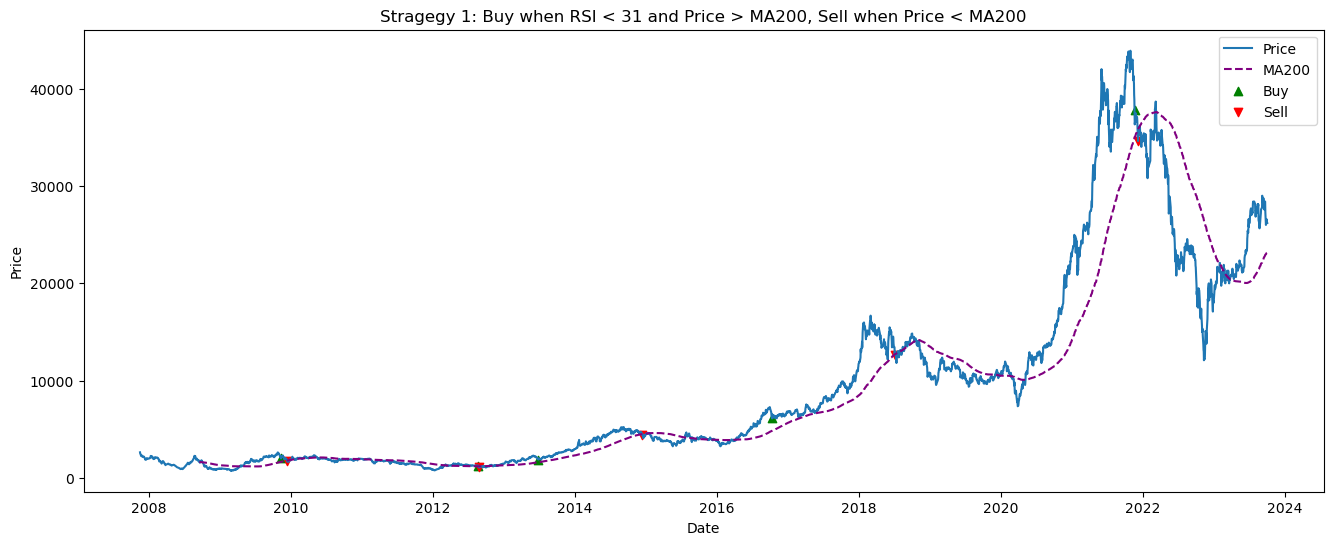

In [14]:
df['GIÁ'] = pd.to_numeric(df['GIÁ'], errors='coerce')

# Calculate the RSI (14)
def calculate_rsi(df):
    delta = df['GIÁ'].diff().dropna()

    # Make two series: one for gains and one for losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the EWMA (Exponential Weighted Moving Average)
    roll_up = gain.ewm(com=13, adjust=False).mean()
    roll_down = loss.ewm(com=13, adjust=False).mean()

    # Calculate the RSI based on EWMA
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    return RSI

# Calculate the moving averages
df['MA200'] = df['GIÁ'].rolling(window=200).mean()

# Calculate the RSI
df['RSI'] = calculate_rsi(df)

# Initialize variables
buy_signal = False
buy_price = 0
signals = []

# Initialize statistics
statistics_strate_2 = {
    'number_of_signals': 0, # 'Number of Signals
    '% Profit Signals': 0,
    'Average Return of Profit Signals': 0,
    'Median Return of Profit Signals': 0,
    '% Loss Signals': 0,
    'Average Return of Loss Signals': 0,
    'Median Return of Loss Signals': 0,
    'Average T+3': 0,
    'Median T+3': 0,
    'Average T+10': 0,
    'Median T+10': 0,
    'Average T+60': 0,
    'Median T+60': 0,
    'Average T+180': 0,
    'Median T+180': 0,
    'Average T+360': 0,
    'Median T+360': 0
}

# Iterate through the DataFrame to generate buy and sell signals
for i in range(200, len(df)):
    if not buy_signal and df['RSI'][i] < 31 and df['GIÁ'][i] > df['MA200'][i]:
        buy_signal = True
        buy_price = df['GIÁ'][i]
        buy_time = df['NGÀY'][i]
        index_buy = i
    elif buy_signal and df['GIÁ'][i] < df['MA200'][i]:
        sell_price = df['GIÁ'][i]
        sell_time = df['NGÀY'][i]
        index_sell = i
        return_percentage = ((sell_price - buy_price) / buy_price) * 100
        signals.append([buy_time, sell_time, index_sell - index_buy, buy_price, sell_price, return_percentage, index_buy, index_sell])
        buy_signal = False

# Create a DataFrame for the backtest results
backtest_df2 = pd.DataFrame(signals, columns=['Buy Time (T)', 'Sell Time', 'Trading Days Hold', 'Buy Price', 'Sell Price', 'Return', 'Index Buy', 'Index Sell'])

# Calculate and append the statistics for holding periods (T+3, T+10, T+60, T+180, T+360)
hold_periods = [3, 10, 60, 180, 360]
for period in hold_periods:
    column_name = f'T+{period}'
    backtest_df2[column_name] = backtest_df2.apply(lambda row: ((df['GIÁ'].iloc[row['Index Buy'] + period] - row['Buy Price']) / row['Buy Price']) * 100 if (row['Index Buy'] + period) < len(df) else 0, axis=1)

# Calculate the requested statistics
number_of_signals = len(signals)
profit_signals = backtest_df2[backtest_df2['Return'] > 0]
loss_signals = backtest_df2[backtest_df2['Return'] < 0]
profit_percentage = (len(profit_signals) / number_of_signals) * 100

if number_of_signals > 0:
    statistics_strate_2['number_of_signals'] = number_of_signals
    statistics_strate_2['% Profit Signals'] = profit_percentage
    statistics_strate_2['Average Return of Profit Signals'] = profit_signals['Return'].mean()
    statistics_strate_2['Median Return of Profit Signals'] = profit_signals['Return'].median()
    statistics_strate_2['% Loss Signals'] = 100 - profit_percentage
    statistics_strate_2['Average Return of Loss Signals'] = loss_signals['Return'].mean()
    statistics_strate_2['Median Return of Loss Signals'] = loss_signals['Return'].median()
    statistics_strate_2['Average T+3'] = backtest_df2['T+3'].mean()
    statistics_strate_2['Median T+3'] = backtest_df2['T+3'].median()
    statistics_strate_2['Average T+10'] = backtest_df2['T+10'].mean()
    statistics_strate_2['Median T+10'] = backtest_df2['T+10'].median()
    statistics_strate_2['Average T+60'] = backtest_df2['T+60'].mean()
    statistics_strate_2['Median T+60'] = backtest_df2['T+60'].median()
    statistics_strate_2['Average T+180'] = backtest_df2['T+180'].mean()
    statistics_strate_2['Median T+180'] = backtest_df2['T+180'].median()
    statistics_strate_2['Average T+360'] = backtest_df2['T+360'].mean()
    statistics_strate_2['Median T+360'] = backtest_df2['T+360'].median()

# Display the backtest results
print("Backtest Table:")
print(backtest_df2)
print("\nBacktest Statistics:")
print(f'Number of Signals: {number_of_signals}')
for key, value in statistics_strate_2.items():
    print(f"{key}: {value:.1f}%")

# Plot the price chart
plt.figure(figsize=(12, 6))
plt.plot(df['NGÀY'], df['GIÁ'], label='Price')

# Plot the MA200 line
plt.plot(df['NGÀY'], df['MA200'], label='MA200', linestyle='--', color='purple')

# Plot the buy and sell points
plt.scatter(backtest_df2['Buy Time (T)'], backtest_df2['Buy Price'], marker='^', color='g', label='Buy')
plt.scatter(backtest_df2['Sell Time'], backtest_df2['Sell Price'], marker='v', color='r', label='Sell')

plt.gcf().set_size_inches(16, 6)

# Set title and labels for the axes
plt.title('Stragegy 1: Buy when RSI < 31 and Price > MA200, Sell when Price < MA200')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Display the chart
plt.show()


## Strategy   : MA20 Cross Up MA50 and Current Price > MA200

Backtest Table:
   Buy Time (T)  Sell Time  Trading Days Hold     Buy Price    Sell Price  \
0    2010-12-14 2011-01-27                 31   2010.397505   1969.680506   
1    2012-10-23 2013-07-02                169   1315.651926   1993.454677   
2    2013-08-06 2014-10-09                292   2147.877247   5014.085164   
3    2015-10-14 2015-11-16                 23   4250.016422   3894.751892   
4    2016-12-06 2017-03-06                 58   6384.624205   6431.455189   
5    2017-04-03 2017-05-19                 31   7480.875712   6719.910264   
6    2017-06-15 2017-11-08                103   7586.240159   9266.188964   
7    2017-11-30 2018-04-03                 82  10304.102167  14630.824679   
8    2018-06-19 2018-07-09                 14  13427.577210  12499.726373   
9    2018-08-27 2018-11-02                 48  13637.656645  14005.295655   
10   2021-08-26 2021-11-23                 61  36099.360000  37499.440000   
11   2023-04-17 2023-08-30                 94  20850.000000 

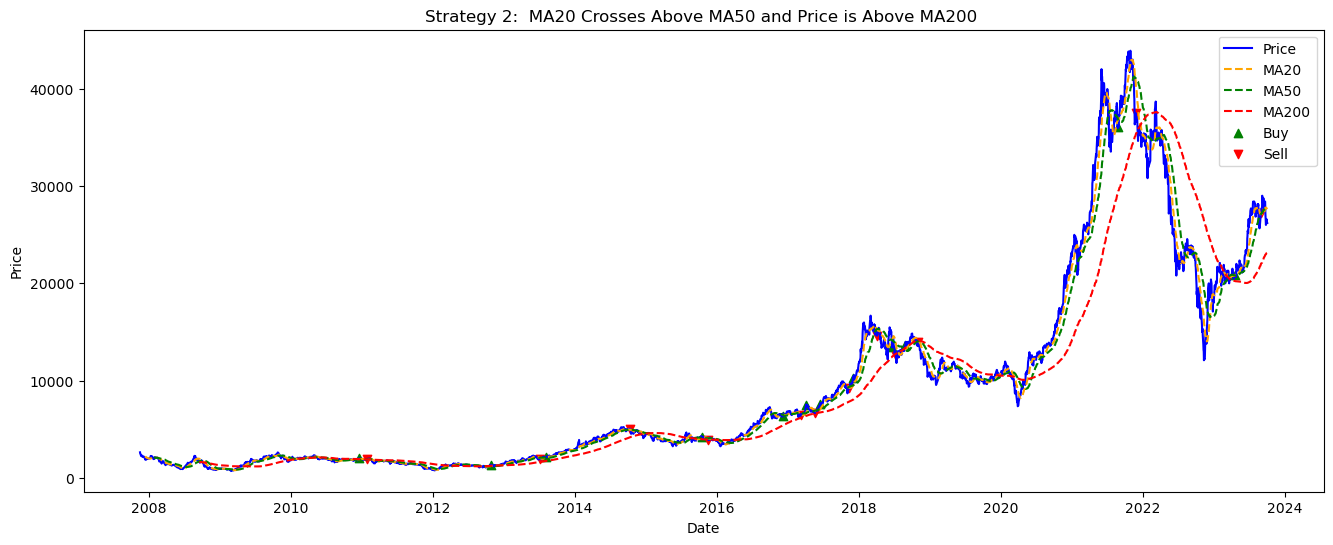

In [15]:
# Calculate the moving averages
df['MA20'] = df['GIÁ'].rolling(window=20).mean()
df['MA50'] = df['GIÁ'].rolling(window=50).mean()
df['MA200'] = df['GIÁ'].rolling(window=200).mean()

# Initialize variables
buy_signal = False
buy_price = 0
signals = []

# Initialize statistics
statistics_strate_1 = {
    'number_of_signals': 0, # 'Number of Signals
    '% Profit Signals': 0,
    'Average Return of Profit Signals': 0,
    'Median Return of Profit Signals': 0,
    '% Loss Signals': 0,
    'Average Return of Loss Signals': 0,
    'Median Return of Loss Signals': 0,
    'Average T+3': 0,
    'Median T+3': 0,
    'Average T+10': 0,
    'Median T+10': 0,
    'Average T+60': 0,
    'Median T+60': 0,
    'Average T+180': 0,
    'Median T+180': 0,
    'Average T+360': 0,
    'Median T+360': 0
}

# Iterate through the DataFrame to generate buy and sell signals
for i in range(200, len(df)):
    if not buy_signal and df['GIÁ'][i] > df['MA200'][i] and df['MA20'][i] > df['MA50'][i] and df['MA20'][i - 1] < df['MA50'][i - 1]:
        buy_signal = True
        buy_price = df['GIÁ'][i]
        buy_time = df['NGÀY'][i]
        index_buy = i
    elif buy_signal and df['MA20'][i] < df['MA50'][i]:
        sell_price = df['GIÁ'][i]
        sell_time = df['NGÀY'][i]
        index_sell = i
        return_percentage = ((sell_price - buy_price) / buy_price) * 100
        signals.append([buy_time, sell_time, index_sell - index_buy, buy_price, sell_price, return_percentage, index_buy, index_sell])
        buy_signal = False

# Create a DataFrame for the backtest results
backtest_df = pd.DataFrame(signals, columns=['Buy Time (T)', 'Sell Time', 'Trading Days Hold', 'Buy Price', 'Sell Price', 'Return', 'Index Buy', 'Index Sell'])

# Calculate and append the statistics for holding periods (T+3, T+10, T+60, T+180, T+360)
hold_periods = [3, 10, 60, 180, 360]
for period in hold_periods:
    column_name = f'T+{period}'
    backtest_df[column_name] = backtest_df.apply(lambda row: ((df['GIÁ'].iloc[row['Index Buy'] + period] - row['Buy Price']) / row['Buy Price']) * 100 if (row['Index Buy'] + period) < len(df) else 0, axis=1)

# Calculate the requested statistics
number_of_signals = len(signals)
profit_signals = backtest_df[backtest_df['Return'] > 0]
loss_signals = backtest_df[backtest_df['Return'] < 0]
profit_percentage = (len(profit_signals) / number_of_signals) * 100

if number_of_signals > 0:
    statistics_strate_1['number_of_signals'] = number_of_signals
    statistics_strate_1['% Profit Signals'] = profit_percentage
    statistics_strate_1['Average Return of Profit Signals'] = profit_signals['Return'].mean()
    statistics_strate_1['Median Return of Profit Signals'] = profit_signals['Return'].median()
    statistics_strate_1['% Loss Signals'] = 100 - profit_percentage
    statistics_strate_1['Average Return of Loss Signals'] = loss_signals['Return'].mean()
    statistics_strate_1['Median Return of Loss Signals'] = loss_signals['Return'].median()
    statistics_strate_1['Average T+3'] = backtest_df['T+3'].mean()
    statistics_strate_1['Median T+3'] = backtest_df['T+3'].median()
    statistics_strate_1['Average T+10'] = backtest_df['T+10'].mean()
    statistics_strate_1['Median T+10'] = backtest_df['T+10'].median()
    statistics_strate_1['Average T+60'] = backtest_df['T+60'].mean()
    statistics_strate_1['Median T+60'] = backtest_df['T+60'].median()
    statistics_strate_1['Average T+180'] = backtest_df['T+180'].mean()
    statistics_strate_1['Median T+180'] = backtest_df['T+180'].median()
    statistics_strate_1['Average T+360'] = backtest_df['T+360'].mean()
    statistics_strate_1['Median T+360'] = backtest_df['T+360'].median()

# Display the backtest results
print("Backtest Table:")
print(backtest_df)
print("\nBacktest Statistics:")
print(f'Number of Signals: {number_of_signals}')
for key, value in statistics_strate_1.items():
    print(f"{key}: {value:.1f}%")

# Plot the price chart
plt.figure(figsize=(12, 8))
plt.plot(df['NGÀY'], df['GIÁ'], label='Price', color='blue')

# Plot the MA20, MA50, MA200 lines
plt.plot(df['NGÀY'], df['MA20'], label='MA20', linestyle='--', color='orange')
plt.plot(df['NGÀY'], df['MA50'], label='MA50', linestyle='--', color='green')
plt.plot(df['NGÀY'], df['MA200'], label='MA200', linestyle='--', color='red')

# Plot the buy and sell points
plt.scatter(backtest_df['Buy Time (T)'], backtest_df['Buy Price'], marker='^', color='g', label='Buy')
plt.scatter(backtest_df['Sell Time'], backtest_df['Sell Price'], marker='v', color='r', label='Sell')


plt.gcf().set_size_inches(16, 6)

# Set title and labels for the axes
plt.title('Strategy 2:  MA20 Crosses Above MA50 and Price is Above MA200 ')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Display the chart
plt.show()


## Strategy   : Golden Cross and Death Cross MA50 - MA200

Backtest Table:
  Buy Time (T)  Sell Time  Trading Days Hold     Buy Price    Sell Price  \
0   2009-05-25 2010-01-27                175   1636.731061   1933.946420   
1   2010-04-09 2010-06-03                 36   2175.689591   2030.542057   
2   2011-01-27 2011-03-04                 20   1969.680506   1511.615315   
3   2012-04-16 2012-09-27                115   1511.600183   1102.908341   
4   2012-12-19 2015-01-16                514   1410.860583   4542.675448   
5   2015-08-31 2016-01-13                 95   4092.121076   3618.435035   
6   2016-05-09 2018-08-20                575   4460.543552  13042.431579   
7   2020-01-10 2020-03-27                 50  11015.605657   7374.083126   
8   2020-06-09 2022-01-12                403  12335.657575  34964.160000   

       Return  Index Buy  Index Sell       T+3       T+10       T+60  \
0   18.159083        370         545 -7.184470  15.533976  31.067959   
1   -6.671335        592         628 -0.740736   2.222226 -12.893240   
2  -23.

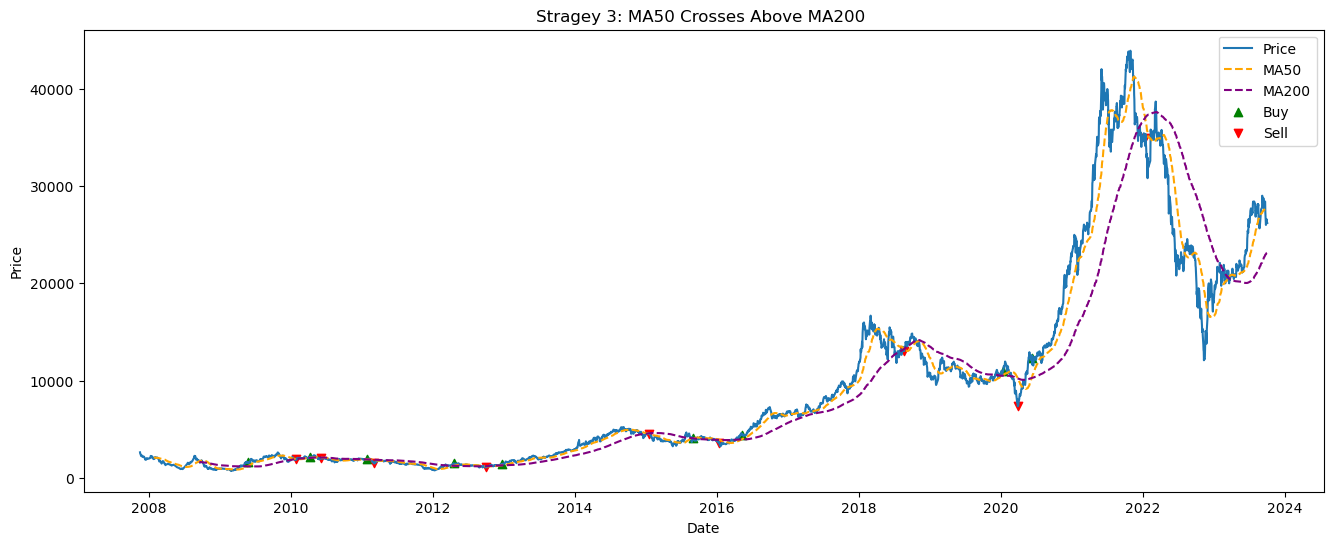

In [16]:
# Calculate the moving averages
df['MA50'] = df['GIÁ'].rolling(window=50).mean()
df['MA200'] = df['GIÁ'].rolling(window=200).mean()

# Initialize variables
buy_signal = False
buy_price = 0
signals = []

# Initialize statistics
statistics_strate_3 = {
    'number_of_signals': 0, # 'Number of Signals
    '% Profit Signals': 0,
    'Average Return of Profit Signals': 0,
    'Median Return of Profit Signals': 0,
    '% Loss Signals': 0,
    'Average Return of Loss Signals': 0,
    'Median Return of Loss Signals': 0,
    'Average T+3': 0,
    'Median T+3': 0,
    'Average T+10': 0,
    'Median T+10': 0,
    'Average T+60': 0,
    'Median T+60': 0,
    'Average T+180': 0,
    'Median T+180': 0,
    'Average T+360': 0,
    'Median T+360': 0
}

# Iterate through the DataFrame to generate buy and sell signals
for i in range(200, len(df)):
    if not buy_signal and df['MA50'][i] > df['MA200'][i] and df['MA50'][i-1] < df['MA200'][i-1]:
        buy_signal = True
        buy_price = df['GIÁ'][i]
        buy_time = df['NGÀY'][i]
        index_buy = i
    elif buy_signal and df['MA50'][i] < df['MA200'][i]:
        sell_price = df['GIÁ'][i]
        sell_time = df['NGÀY'][i]
        index_sell = i
        return_percentage = ((sell_price - buy_price) / buy_price) * 100
        signals.append([buy_time, sell_time, index_sell - index_buy, buy_price, sell_price, return_percentage, index_buy, index_sell])
        buy_signal = False

# Create a DataFrame for the backtest results
backtest_df3 = pd.DataFrame(signals, columns=['Buy Time (T)', 'Sell Time', 'Trading Days Hold', 'Buy Price', 'Sell Price', 'Return', 'Index Buy', 'Index Sell'])

# Calculate and append the statistics for holding periods (T+3, T+10, T+60, T+180, T+360)
hold_periods = [3, 10, 60, 180, 360]
for period in hold_periods:
    column_name = f'T+{period}'
    backtest_df3[column_name] = backtest_df3.apply(lambda row: ((df['GIÁ'].iloc[row['Index Buy'] + period] - row['Buy Price']) / row['Buy Price']) * 100 if (row['Index Buy'] + period) < len(df) else 0, axis=1)

# Calculate the requested statistics
number_of_signals = len(signals)
profit_signals = backtest_df3[backtest_df3['Return'] > 0]
loss_signals = backtest_df3[backtest_df3['Return'] < 0]
profit_percentage = (len(profit_signals) / number_of_signals) * 100

if number_of_signals > 0:
    statistics_strate_3['number_of_signals'] = number_of_signals
    statistics_strate_3['% Profit Signals'] = profit_percentage
    statistics_strate_3['Average Return of Profit Signals'] = profit_signals['Return'].mean()
    statistics_strate_3['Median Return of Profit Signals'] = profit_signals['Return'].median()
    statistics_strate_3['% Loss Signals'] = 100 - profit_percentage
    statistics_strate_3['Average Return of Loss Signals'] = loss_signals['Return'].mean()
    statistics_strate_3['Median Return of Loss Signals'] = loss_signals['Return'].median()
    statistics_strate_3['Average T+3'] = backtest_df3['T+3'].mean()
    statistics_strate_3['Median T+3'] = backtest_df3['T+3'].median()
    statistics_strate_3['Average T+10'] = backtest_df3['T+10'].mean()
    statistics_strate_3['Median T+10'] = backtest_df3['T+10'].median()
    statistics_strate_3['Average T+60'] = backtest_df3['T+60'].mean()
    statistics_strate_3['Median T+60'] = backtest_df3['T+60'].median()
    statistics_strate_3['Average T+180'] = backtest_df3['T+180'].mean()
    statistics_strate_3['Median T+180'] = backtest_df3['T+180'].median()
    statistics_strate_3['Average T+360'] = backtest_df3['T+360'].mean()
    statistics_strate_3['Median T+360'] = backtest_df3['T+360'].median()

# Display the backtest results
print("Backtest Table:")
print(backtest_df3)
print("\nBacktest Statistics:")
print(f'Number of Signals: {number_of_signals}')
for key, value in statistics_strate_3.items():
    print(f"{key}: {value:.1f}%")

# Plot the price chart
plt.figure(figsize=(12, 6))
plt.plot(df['NGÀY'], df['GIÁ'], label='Price')

# Plot the MA50 and MA200 lines
plt.plot(df['NGÀY'], df['MA50'], label='MA50', linestyle='--', color='orange')
plt.plot(df['NGÀY'], df['MA200'], label='MA200', linestyle='--', color='purple')

# Plot the buy and sell points
plt.scatter(backtest_df3['Buy Time (T)'], backtest_df3['Buy Price'], marker='^', color='g', label='Buy')
plt.scatter(backtest_df3['Sell Time'], backtest_df3['Sell Price'], marker='v', color='r', label='Sell')

plt.gcf().set_size_inches(16, 6)

# Set title and labels for the axes
plt.title('Stragey 3: MA50 Crosses Above MA200 ')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Display the chart
plt.show()


In [17]:
# Sau khi tính toán chiến lược 1
# ... (Đoạn mã tính toán chiến lược 1)
strategies_data = {}
# Lưu kết quả vào strategies_data
strategies_data['Chiến lược MA200 và RSI 30'] = {
    'number_of_signals': statistics_strate_2['number_of_signals'],
    '% Profit Signals': statistics_strate_2['% Profit Signals'],
    'Average Return of Profit Signals': statistics_strate_2['Average Return of Profit Signals'],
    'Median Return of Profit Signals': statistics_strate_2['Median Return of Profit Signals'],
    '% Loss Signals': statistics_strate_2['% Loss Signals'],
    'Average Return of Loss Signals': statistics_strate_2['Average Return of Loss Signals'],
    'Median Return of Loss Signals': statistics_strate_2['Median Return of Loss Signals']
}

# Chiến lược 2
# ... (Đoạn mã tính toán chiến lược 2)

# Lưu kết quả vào strategies_data
strategies_data['Chiến lược MA20 cắt lên MA50 khi đang trên MA200'] = {
    'number_of_signals': statistics_strate_1['number_of_signals'], # 'number_of_signals' là số lượng tín hiệu được tạo ra
    '% Profit Signals': statistics_strate_1['% Profit Signals'],
    'Average Return of Profit Signals': statistics_strate_1['Average Return of Profit Signals'],
    'Median Return of Profit Signals': statistics_strate_1['Median Return of Profit Signals'],
    '% Loss Signals': statistics_strate_1['% Loss Signals'],
    'Average Return of Loss Signals': statistics_strate_1['Average Return of Loss Signals'],
    'Median Return of Loss Signals': statistics_strate_1['Median Return of Loss Signals']
}

# Chiến lược 3
# ... (Đoạn mã tính toán chiến lược 3)

# Lưu kết quả vào strategies_data
strategies_data['Chiến lược đường cắt vàng MA50 và MA200'] = {
    'number_of_signals': statistics_strate_3['number_of_signals'],
    '% Profit Signals': statistics_strate_3['% Profit Signals'],
    'Average Return of Profit Signals': statistics_strate_3['Average Return of Profit Signals'],
    'Median Return of Profit Signals': statistics_strate_3['Median Return of Profit Signals'],
    '% Loss Signals': statistics_strate_3['% Loss Signals'], # '% Loss Signals' là tỷ lệ tín hiệu lỗ
    'Average Return of Loss Signals': statistics_strate_3['Average Return of Loss Signals'],
    'Median Return of Loss Signals': statistics_strate_3['Median Return of Loss Signals']
}



# Tạo DataFrame từ dictionary
strategies_df = pd.DataFrame(strategies_data)



# Format các số thành dạng có một chữ số sau dấu thập phân
strategies_df = strategies_df.round(1)

# Hiển thị DataFrame sau khi đã được format
strategies_df

,Chiến lược MA200 và RSI 30,Chiến lược MA20 cắt lên MA50 khi đang trên MA200,Chiến lược đường cắt vàng MA50 và MA200
number_of_signals,5.0,12.0,9.0
% Profit Signals,40.0,66.7,44.4
Average Return of Profit Signals,120.4,35.9,154.0
Median Return of Profit Signals,120.4,26.3,187.9
% Loss Signals,60.0,33.3,55.6
Average Return of Loss Signals,-7.9,-6.9,-20.3
Median Return of Loss Signals,-8.4,-7.6,-23.3
